In [ ]:
!pip install -q replay-rec rs_datasets

In [ ]:
from datetime import datetime

import matplotlib.pyplot  as plt
import numpy as np
import pandas as pd
import seaborn as sns
from rs_datasets import MovieLens
from replay.metrics import Experiment, HitRate, NDCG, Coverage, OfflineMetrics
from replay.preprocessing.filters import MinCountFilter, LowRatingFilter
from replay.splitters.time_splitter import TimeSplitter
from sklearn.preprocessing import OrdinalEncoder
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

# 0. Загрузка датасета Movielens-1m

In [ ]:
ml = MovieLens('1m')
data = ml.ratings

Оставляем пользователей с не менее чем 20 взаимодействиями.

In [ ]:
data = MinCountFilter(num_entries=20).transform(data)

### Разбиение данных

In [ ]:
train, test = TimeSplitter(time_threshold=0.2,
                           drop_cold_users=True,
                           drop_cold_items=True,
                           query_column='user_id').split(data)

In [ ]:
print('Юзеров в train = {}'.format(train.user_id.nunique()))
print('Айтемов в train = {}'.format(train.item_id.nunique()))

Юзеров в train = 5400
Айтемов в train = 3662


Тестовая выборка будет содержать фильмы с оценкой не менее 4

In [ ]:
test = LowRatingFilter(value=4).transform(test)
test = test[test['user_id'].isin(train['user_id'].unique())]

Применим энкодинг. Чтобы id юзера и айтема были их индексами в разряженной матрице.


In [ ]:
# Применяем энкодинг, чтобы id айтема и юзера был его индексом для удобства
enc = OrdinalEncoder()
train[['user_id','item_id']] = enc.fit_transform(train[['user_id','item_id']]).astype(int)
test[['user_id','item_id']] = enc.transform(test[['user_id','item_id']]).astype(int)

# 1. Построение *ItemKNN*

$$
r_{ui} = \frac{\sum_{i' \in J}\limits \text{sim}(i,i') \times r_{ui'}}{\sum_{i' \in J}\limits \text{sim}(i,i')}
$$



## 1.1 Первая версия

In [ ]:
log = pd.pivot_table(train, values='rating', index='user_id', columns='item_id').fillna(0).to_numpy()

In [ ]:
def get_item_item_similarity(log):
    log = log / np.linalg.norm(log, axis=0, keepdims=True)
    item_item_similarity = log.T @ log

    return item_item_similarity

In [ ]:
def make_predict(item_item_similarity, log, test, k_neighbours=50):
    num_users = log.shape[0]
    num_items = log.shape[1]

    k_neighbours_ids = np.argsort(item_item_similarity, axis=1)[:, -k_neighbours-1:][:,-2::-1]
    ratings = np.zeros((num_users, num_items))

    for user in tqdm(test.user_id.unique()):
        for item in train.item_id.unique():
            user_item_score = 0
            total_weight = 0
            for neighbour_item in k_neighbours_ids[item]:
                user_item_score += log[user][neighbour_item] * item_item_similarity[item][neighbour_item]

            ratings[user][item] = user_item_score / np.sum(item_item_similarity[item][k_neighbours_ids[item]])

    return ratings

In [ ]:
def predict_to_pandas(ratings, topk=10):
    ind_part = np.argpartition(ratings, -topk)[:, -topk:].copy()
    scores_not_sorted = np.take_along_axis(ratings, ind_part, axis=1)
    ind_sorted = np.argsort(scores_not_sorted, axis=1)
    scores_sorted = np.sort(scores_not_sorted, axis=1)
    indices = np.take_along_axis(ind_part, ind_sorted, axis=1)

    pred = pd.DataFrame({
        'user_id': range(ratings.shape[0]),
        'item_id': list(indices),
        'rating': list(scores_sorted)
    }).explode(['item_id', 'rating'])

    test_user = test['user_id'].unique()
    pred = pred[pred['user_id'].isin(test_user)]

    return pred

In [ ]:
item_item_similarity = get_item_item_similarity(log)

In [ ]:
%%time
ratings_base = make_predict(item_item_similarity, log, test, k_neighbours=10)

100%|██████████| 1122/1122 [01:21<00:00, 13.80it/s]

CPU times: user 1min 22s, sys: 449 ms, total: 1min 22s
Wall time: 1min 22s


In [ ]:
predictions_base = predict_to_pandas(ratings_base, topk=10)

In [ ]:
metrics = [HitRate(topk=10), NDCG(topk=10), Coverage(topk=10)]
OfflineMetrics(metrics, query_column='user_id')(predictions_base, test, train)

{'HitRate@10': 0.34402852049910876,
 'NDCG@10': 0.06561630215818796,
 'Coverage@10': 0.3484434735117422}

## 1.2 Фильтрация просмотренных айтемов из предсказаний

In [ ]:
def filter_seen(ratings, train_log):
    ratings = np.multiply(ratings, np.invert(train_log.astype(bool)))
    return ratings

In [ ]:
ratings_filtered = filter_seen(ratings_base, log)

In [ ]:
predictions_filtered = predict_to_pandas(ratings_filtered, topk=10)

In [ ]:
OfflineMetrics(metrics, query_column='user_id')(predictions_filtered, test, train)

{'HitRate@10': 0.5837789661319073,
 'NDCG@10': 0.15463462189923483,
 'Coverage@10': 0.375204806116876}

# 2. Сравнение моделей

## 2.1 Прогресс метрик

In [ ]:
exp = Experiment(
    metrics,
    query_column='user_id',
    ground_truth=test,
    train=train
)

In [ ]:
exp.add_result('BaseKnn', predictions_base)
exp.add_result('FilteredKnn', predictions_filtered)

In [ ]:
exp.results

,HitRate@10,NDCG@10,Coverage@10
BaseKnn,0.344029,0.065616,0.348443
FilteredKnn,0.583779,0.154635,0.375205


In [ ]:
exp.results.sort_values(by='NDCG@10')

,HitRate@10,NDCG@10,Coverage@10
BaseKnn,0.344029,0.065616,0.348443
FilteredKnn,0.583779,0.154635,0.375205


## 2.2 Сравнение $k$

In [ ]:
ndcg_metrics = []

item_item_similarity = get_item_item_similarity(log)
for k_neighbours in range(10, 60, 10):
    ratings = make_predict(item_item_similarity, log, test, k_neighbours=k_neighbours)
    ratings_filter = filter_seen(ratings, log)
    predict = predict_to_pandas(ratings_filter, topk=10)
    ndcg_metrics.append(NDCG(topk=10, query_column='user_id')(ground_truth=test, recommendations=predict)['NDCG@10'])

100%|██████████| 1122/1122 [03:54<00:00,  4.79it/s]


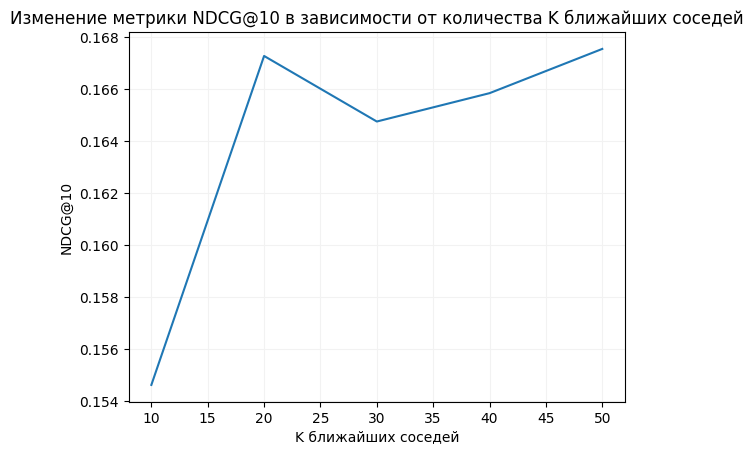

In [ ]:
plt.title('Изменение метрики NDCG@10 в зависимости от количества K ближайших соседей')
plt.plot(range(10, 60, 10), ndcg_metrics)
plt.grid(axis='x', color='0.95')
plt.grid(axis='y', color='0.95')
plt.xlabel('K ближайших соседей')
plt.ylabel('NDCG@10')
plt.show()

### 2.3 Визуализация рейтингов, восстановленных ItemKNN

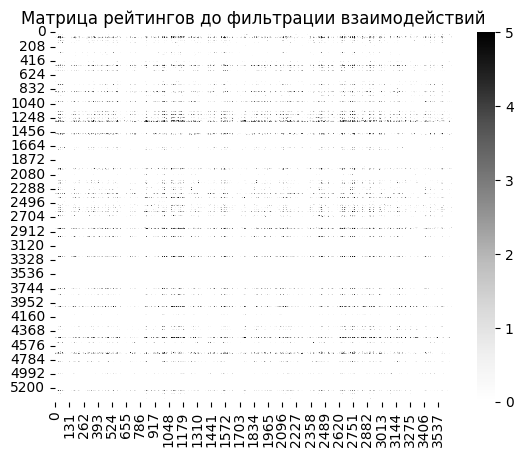

In [ ]:
plt.title('Матрица рейтингов до фильтрации взаимодействий')
sns.heatmap(ratings_base, cmap='Greys');

<Axes: title={'center': 'Матрица рейтингов после фильтрации взаимодействий'}>

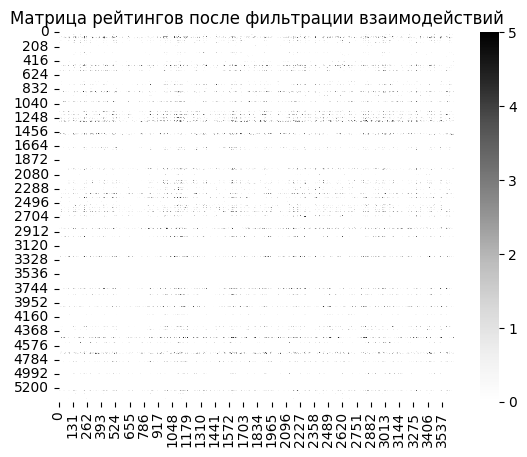

In [ ]:
plt.title('Матрица рейтингов после фильтрации взаимодействий')
sns.heatmap(ratings_filtered, cmap='Greys');